Dans ce notebook, nous avons créé un moteur de recherche qui parcourt la collection de questions StackOverFlow Python et récupère les questions et les tags les plus similaires à la question d'entrée

In [229]:
from IPython.core.display import display
!pip install transformers

In [230]:
!pip install simpletransformers==0.32.3

In [231]:
!pip install wordcloud

In [232]:
!pip install torch

In [233]:
import pandas as pd
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud , STOPWORDS
import matplotlib.pyplot as plt
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from tqdm.notebook import tqdm
import torch

pd.set_option('display.max_colwidth', None)

<ipython-input-233-4b20c2430cbd>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [234]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedecabre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [235]:
#questions = pd.read_csv("input/Questions.csv", encoding = "ISO-8859-1")
#print(len(questions))
#display(questions.head(5))

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str'}

nrows = 1000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )

df_tags_list = pd.read_csv('tags_list.csv',
                           usecols=['Id', 'Tags'],
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           #nrows=nrows # un post peut avoir plusieurs tags
                          )
print(len(df_questions))
display(df_questions.head(5))
display(df_tags_list.head(5))

1000


,Id,Title,Body,Score,Title_raw,Text
0,1544907,melt two column,follow variable data frame type ialt idx idx idx farve farve dm meltd idctypeialt get variable type ialt value idx idx idx farve farve represent really want something like type ialt value value farve farve represent value reason want would like something line color value fall rise edit shane show reshape data via two melt merge strategy seam ill conceive begin one word see shanes solution ggplotdm labeltypesizeialt geomline geomtextdatasubsetdm variableidxhjust size themebw scalexdiscreteexpandc optslegendpositionnone assume need cast figure data structurelisttype structurecl label calvorligere andre strafferetlige rlove andre bedrageri brandstiftelse mv dokumentfalsk rdselslovovertr vrigt rdselsuheld med falsk forklaring forbr mod myndighed freds og rekr leri rv rk bank forretn mv indbrud fritidshuse garager mv indbrud villaer lejligheder mv love vedr og lign love vedr spil bev ring euforiserende stoffer mangler ved veri simpel vold spiritus og promillek rsel trusler tyvbrugstyv af andet tyvbrugstyv af cykel tyvbrugstyv af indr ret tyvbrugstyv af knallert tyveri fra bil mv omgang med hittegods benloven vold mod myndighed class factor ialt cl idx idx idx farve cgreen green green green green green green green red green green green red green green green green farve cred green green red green green green green green green red name ctype ialt idx idx idx farve farve class dataframe rownames cna,26,melt to two variable columns,melt two column follow variable data frame type ialt idx idx idx farve farve dm meltd idctypeialt get variable type ialt value idx idx idx farve farve represent really want something like type ialt value value farve farve represent value reason want would like something line color value fall rise edit shane show reshape data via two melt merge strategy seam ill conceive begin one word see shanes solution ggplotdm labeltypesizeialt geomline geomtextdatasubsetdm variableidxhjust size themebw scalexdiscreteexpandc optslegendpositionnone assume need cast figure data structurelisttype structurecl label calvorligere andre strafferetlige rlove andre bedrageri brandstiftelse mv dokumentfalsk rdselslovovertr vrigt rdselsuheld med falsk forklaring forbr mod myndighed freds og rekr leri rv rk bank forretn mv indbrud fritidshuse garager mv indbrud villaer lejligheder mv love vedr og lign love vedr spil bev ring euforiserende stoffer mangler ved veri simpel vold spiritus og promillek rsel trusler tyvbrugstyv af andet tyvbrugstyv af cykel tyvbrugstyv af indr ret tyvbrugstyv af knallert tyveri fra bil mv omgang med hittegods benloven vold mod myndighed class factor ialt cl idx idx idx farve cgreen green green green green green green green red green green green red green green green green farve cred green green red green green green green green green red name ctype ialt idx idx idx farve farve class dataframe rownames cna
1,195625,time complexity pop element list python,wonder time complexity pop list object python cpython particulary also value affect complexity,55,What is the time complexity of popping elements from list in Python?,time complexity pop element list python wonder time complexity pop list object python cpython particulary also value affect complexity
2,6052631,data monthyear interval,often work date imagine fairly column represent date dataframe simply want dataframe summarize column monthyear use date approach want dataframe feed plot help provide greatly edit reference strtemp dataframe ob variable date posixct format amount num headtemp date amount,62,Aggregate Daily Data to Month/Year intervals,data monthyear interval often work date imagine fairly column represent date dataframe simply want dataframe summarize column monthyear use date approach want dataframe feed plot help provide greatly edit reference strtemp dataframe ob variable date posixct format amount num headtemp date amount
3,8809004,escape roxygen style documentation,let u say comm

,Id,Tags
0,1544907,r
1,1544907,ggplot2
2,1544907,reshape
3,195625,python
4,6052631,datetime


In [236]:
print(df_questions[['Title','Body']].head(10))


                                                   Title  \
0  melt two column                                         
1  time complexity pop element list python                 
2  data monthyear interval                                 
3  escape roxygen style documentation                      
4  loop select item list                                   
5  change date format                                      
6  question setuptools alternative                         
7  python                                                  
8  formula call variable build model                       
9  manipulateaccess element instance dist class use core   

                                                                                                                                                                                                                                                                                                                                                   

In [237]:

print("Nombre de questions uniques : ", df_questions['Id'].nunique())

Nombre de questions uniques :  1000


In [239]:
df_questions['qTitle'] = df_questions['Title'].apply(lambda x : len(str(x).split(" ")))
df_questions['qBody'] = df_questions['Body'].apply(lambda x : len(str(x).split(" ")))
df_questions['qText'] = df_questions['Text'].apply(lambda x : len(str(x).split(" ")))

In [240]:
print('Longueur moyen des Titres : ',df_questions['qTitle'].mean())
print('Longueur moyen des Post : ',df_questions['qBody'].mean())

Longueur moyen des Titres :  4.04
Longueur moyen des Post :  40.349


## Nombre de mots dans le titre et le corps

Text(0.5, 1.0, 'Nombre de mots dans le Titre')

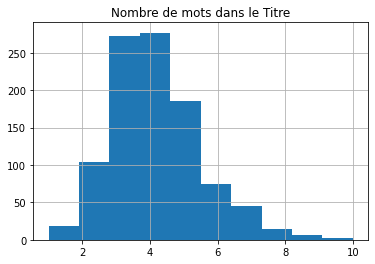

In [241]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qTitle'].hist(bins=10)
plt.title("Nombre de mots dans le Titre")

Text(0.5, 1.0, 'Nombre de mots dans les post')

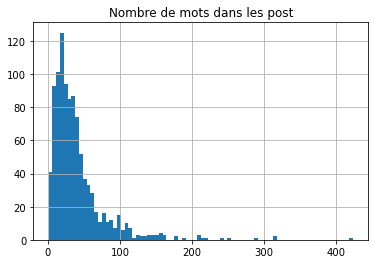

In [242]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qBody'].hist(bins=80)
plt.title("Nombre de mots dans les post")

## La plupart des titres ont environ 7 mots tandis que pour Body, il se situe autour de 35. Donc, pour obtenir les questions les plus similaires, nous allons utiliser le Title au lieu de Body.

## Word Cloud

In [243]:
def getWordCloud(df,col):
    comment_words = ''
    stopwords = set(STOPWORDS)
    stopwords.add('nan')
    stopwords.add('use')
    stopwords.add('way')
    stopwords.add('one')

    for val in tqdm(df[col]):

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

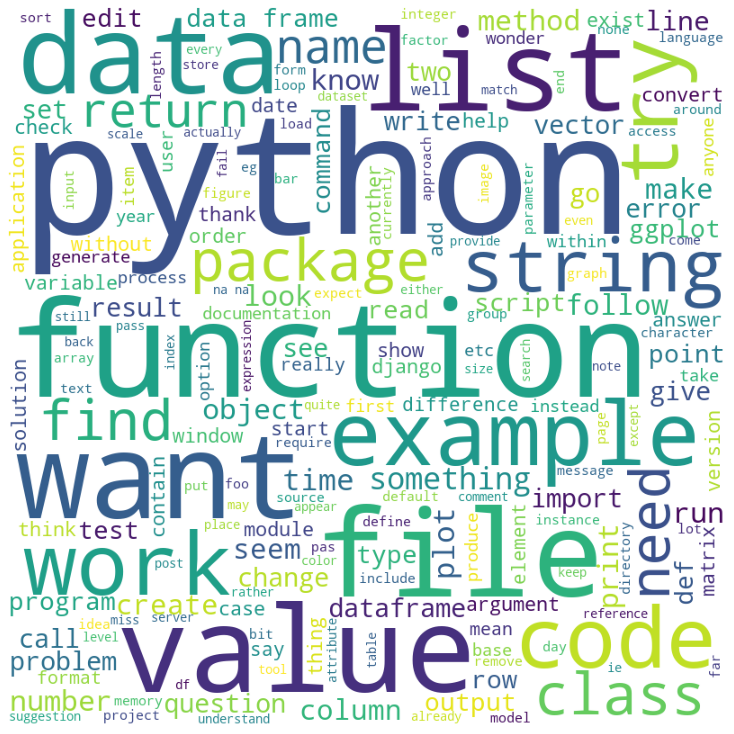

In [244]:
getWordCloud(df_questions,'Text')

## Prétraitement du titre - Suppression des mots vides, des caractères non alphanumériques et de tous les caractères en minuscules.

In [245]:
stop = stopwords.words('english')
def preprocess(df, col):
    df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in x.split(" ") if word not in stop]))
    df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
    df['preprocessed'+col] = df['preprocessed'+col].str.lower()
    return df

In [246]:
questions = preprocess(questions, 'Title')

<ipython-input-245-9fa6568cbb61>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')


## Tags

In [247]:
tags = pd.read_csv("input/Tags.csv", encoding = "ISO-8859-1")
print(len(tags))
display(tags.head(5))

1885078


,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [248]:
print("Nombre de tags uniques : ", tags['Tag'].nunique())
print("Nombre de tags uniques : ", df_tags_list['Tags'].nunique())

Nombre de tags uniques :  16895
Nombre de tags uniques :  1160


20 Tags les plus fréquents Sauf Python et r qui sont évidemment le plus fréquent.

<ipython-input-249-6be55a912b2f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')


<AxesSubplot:>

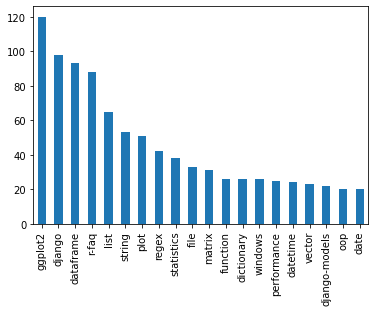

In [249]:
fig, ax = plt.subplots()

fig.patch.set_facecolor('w')
df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## Encoding the Processed Question Title and Embedding it using GPT2 Tokenizer. 

In [250]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [251]:
preprocessedTitle = df_questions['Title'].values
QID = df_questions['Id'].values
print(len(preprocessedTitle), len(QID))

1000 1000


Utilisation de tokenizer.batch_encode_plus pour encoder tous les titres en une seule fois. Au lieu de tokenizer.batch_encode_plus, tokenizer.encode peut être utilisé pour encoder 1 instance à la fois

In [252]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

1000


Chargement de l’embedding à partir du modèle GPT2. Chaque token dans la "embedding matrix”  est un vecteur de longueur 768 et l’embedding a 50257 uniques tokens.

In [253]:
embeddigs = model.transformer.wte
print("Shape de l' embedding matrix : ",embeddigs.weight.shape)
print("Type de l' embedding matrix : ", type(embeddigs))

Shape de l' embedding matrix :  torch.Size([50257, 768])
Type de l' embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


## Dans le code ci-dessous, Nous avons pris la moyenne à travers des embeddings de tous les tokens dans un titre particulier. Ainsi, après avoir pris la moyenne, chaque titre serait représenté par un vecteur de longueur 768. Et la même chose a été faite pour tous les 607282 titres dans une boucle for.
## Remarque - Il peut y avoir des cas où le nombre de jetons dans le titre traité peut être égal à 0, d'où la condition de len (encodedTitle)> 0 a été appliquée.

In [254]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
    if len(encodedTitle) > 0 :
        embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
        TitleEmbeddingList.append(embeddedTitle)
        QIDList.append(qid)

0it [00:00, ?it/s]

In [255]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Nombre de Titres : ",numQ," et longueur du vecteur de chaque titre : ",embedDim)

Nombre de Titres :  1000  et longueur du vecteur de chaque titre :  768


In [256]:
print("Type de TitleEmbeddingList : ",type(TitleEmbeddingList))

Type de TitleEmbeddingList :  <class 'list'>


## Conversion de TitleEmbeddingList de "liste de tenseurs" en tenseur.

In [257]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape de TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type de TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

Shape de TitleEmbeddingTensor :  torch.Size([1000, 768])
Type de TitleEmbeddingTensor :  <class 'torch.Tensor'>


# Une fois que nous avons créé la représentation avec l’embedding pour chaque titre. Nous allons maintenant entrer une question et rechercher parmi les titres de question StackOverflow lesquels sont les plus similaires à l'entrée en utilisant la similitude cosinus entre l’embedding de la question d'entrée et les titres.

## PreProcess du texte des titres

In [258]:
def preprocesstext(text):
    text =  " ".join([word for word in text.split(" ") if word not in stop])
    text = re.sub(r'[^a-zA-Z0-9 ]','',text)
    text = text.lower()
    return text

## Effectuer une similarité cosinus entre la question entrée et tous les titres StackOverFlow et obtenir l'index des titres K les plus similaires

In [259]:
def getMostSimilarQuestionsIdx(K, a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
    res = res.tolist()
    mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
    return mostSimIdx

## Afficher les titres de questions les plus similaires avec l'ID de question et les tags associés

In [267]:
def getMostSimilarQuestions(K, input, QuestionDF, QIDList, Tags):
    input = input
    preprocessedinput = preprocesstext(input)
    inputEncoded = tokenizer.batch_encode_plus([preprocessedinput])['input_ids']
    inputEmbedded = embeddigs(torch.tensor(inputEncoded).to(torch.int64)).squeeze(0).mean(axis=0).unsqueeze(0)
    mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, TitleEmbeddingTensor)
    mostSimilarIdx.reverse()
    print("Most similar ",K, " questions of : ",input,'\n')
    for idx, simidx in enumerate(mostSimilarIdx):
        IDQ = QuestionDF[QuestionDF['Id']==QIDList[simidx]][['Id','Title_raw']].values
        parentId = IDQ[0][0]
        simQuestion = IDQ[0][1]
        print((idx+1), "Question Id : ", parentId, "\n", "Question : ",simQuestion)
        similar_tags = Tags[Tags['Id']==QIDList[simidx]][['Tags']].values
        tags_list =  " , ".join([word for word in similar_tags[:,0]])
        print("Tags suggérés : ", tags_list, "\n")

## Test

In [268]:
tag_list=getMostSimilarQuestions(5, "How to MUltiply 2 columns pandas ?", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  How to MUltiply 2 columns pandas ? 

1 Question Id :  3402371 
 Question :  Combine two data frames by rows (rbind) when they have different sets of columns
Tags suggérés :  r , dataframe , r-faq 

2 Question Id :  421178 
 Question :  How do I enable push-notification for IMAP (Gmail) using Python imaplib?
Tags suggérés :  python , gmail , imap 

3 Question Id :  295438 
 Question :  How can one mock/stub python module like urllib
Tags suggérés :  python , unit-testing , testing , mocking 

4 Question Id :  7611810 
 Question :  Converting a factor to numeric without losing information R (as.numeric() doesn't seem to work)
Tags suggérés :  r , r-factor 

5 Question Id :  6709151 
 Question :  How do I combine two data-frames based on two columns?
Tags suggérés :  r , merge , dataframe 



In [269]:
getMostSimilarQuestions(5, "regex pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  regex pandas 

1 Question Id :  6673162 
 Question :  Reproducing lattice dendrogram graph with ggplot2
Tags suggérés :  r , graphics , ggplot2 , lattice , ggdendro 

2 Question Id :  554446 
 Question :  How do I prevent Python's urllib(2) from following a redirect
Tags suggérés :  python , urllib2 

3 Question Id :  309945 
 Question :  How to quote a string value explicitly (Python DB API/Psycopg2)
Tags suggérés :  python , sql , django , psycopg2 

4 Question Id :  454944 
 Question :  Advice on Python/Django and message queues
Tags suggérés :  python , django , message-queue 

5 Question Id :  7827815 
 Question :  Rearrange dataframe to a table, the opposite of "melt"
Tags suggérés :  r , dataframe , reshape 



In [270]:
getMostSimilarQuestions(5, "logistic regression sklearn", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  logistic regression sklearn 

1 Question Id :  6910814 
 Question :  calculate distance between regression line and datapoint
Tags suggérés :  r , plot , distance 

2 Question Id :  3042117 
 Question :  Screening (multi)collinearity in a regression model
Tags suggérés :  r , statistics , regression 

3 Question Id :  2870631 
 Question :  What is the difference between Multiple R-squared and Adjusted R-squared in a single-variate least squares regression?
Tags suggérés :  r , statistics , regression 

4 Question Id :  204017 
 Question :  How do I execute a program from Python? os.system fails due to spaces in path
Tags suggérés :  python , shellexecute 

5 Question Id :  641420 
 Question :  How should I log while using multiprocessing in Python?
Tags suggérés :  python , logging , multiprocessing 



In [271]:
getMostSimilarQuestions(5, "covert csv to json file pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  covert csv to json file pandas 

1 Question Id :  1562124 
 Question :  Merge many data frames from csv files, when ID column is implied?
Tags suggérés :  r , csv , merge , rowname 

2 Question Id :  175240 
 Question :  How do I convert a file's format from Unicode to ASCII using Python?
Tags suggérés :  python , unicode , encoding , file , ascii 

3 Question Id :  3094866 
 Question :  Trimming a huge (3.5 GB) csv file to read into R
Tags suggérés :  r , csv 

4 Question Id :  6124519 
 Question :  R: Import CSV with column names that contain spaces
Tags suggérés :  r , csv 

5 Question Id :  309945 
 Question :  How to quote a string value explicitly (Python DB API/Psycopg2)
Tags suggérés :  python , sql , django , psycopg2 



In [272]:
getMostSimilarQuestions(5, "Build website using python", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  Build website using python 

1 Question Id :  19151 
 Question :  Build a basic Python iterator
Tags suggérés :  python , object , iterator 

2 Question Id :  596729 
 Question :  How do I use python for web development without relying on a framework?
Tags suggérés :  python , performance , web.py 

3 Question Id :  626796 
 Question :  How do I find the Windows common application data folder using Python?
Tags suggérés :  python , windows , application-data , common-files 

4 Question Id :  448837 
 Question :  How do I create a webpage with buttons that invoke various Python scripts on the system serving the webpage?
Tags suggérés :  python , windows , web-services , cgi 

5 Question Id :  189555 
 Question :  How to use Python to login to a webpage and retrieve cookies for later usage?
Tags suggérés :  python , http , authentication , cookies 



In [273]:
getMostSimilarQuestions(5, "How to install Pandas", df_questions ,QIDList, df_tags_list)

Most similar  5  questions of :  How to install Pandas 

1 Question Id :  421178 
 Question :  How do I enable push-notification for IMAP (Gmail) using Python imaplib?
Tags suggérés :  python , gmail , imap 

2 Question Id :  404744 
 Question :  Determining application path in a Python EXE generated by pyInstaller
Tags suggérés :  python , executable , relative-path , pyinstaller 

3 Question Id :  295438 
 Question :  How can one mock/stub python module like urllib
Tags suggérés :  python , unit-testing , testing , mocking 

4 Question Id :  250038 
 Question :  How can I add post-install scripts to easy_install / setuptools / distutils?
Tags suggérés :  python , setuptools , distutils 

5 Question Id :  419235 
 Question :  Anyone know of a good Python based web crawler that I could use?
Tags suggérés :  python , web-crawler 

